This notebook is for experimenting with : <br>
&emsp;&emsp; 1. Method of extracting the data from TSPLIB dataset into a usable format<br>
&emsp;&emsp; 2. Simulated annealing for TSP with QUBO and without.

## Reading TSPLIB data

#### Convert the tsp file into list

In [1]:
file1 = open('bays29.tsp')     #Test Dataset from Symmetric TSP
lines_list = file1.read().splitlines()

In [2]:
distance_list = lines_list[8:37]    #29 lines for distance values of each 29x29 node pairs
nodes_list = lines_list[38:-1]      #29 lines for the nodes coordinate values
# print(distance_list)
# print(nodes_list)

#### Convert the Lists into 2D Matrix

In [3]:
# The list containg the lines are split and null values are removed
distance_matrix = [0 for i in range (29)]
nodes_matrix = [0 for i in range(29)]
for i in range(29):
    d_row = distance_list[i].split(' ')
    d_row = list(filter(None,d_row))
    n_row = nodes_list[i].split(' ')
    n_row = list(filter(None,n_row))
    distance_matrix[i] = d_row
    nodes_matrix[i] = n_row
#print(distance_matrix)
#print(nodes_matrix)
    

In [4]:
# reshaping the matrices
import numpy as np
#Convert the lists to numpy arrays
distance_matrix = np.array(distance_matrix)
nodes_matrix = np.array(nodes_matrix)
distance_matrix = distance_matrix.reshape(29,29)        # Re-shape into 2D array
nodes_matrix = nodes_matrix.reshape(29,3)               # Re-shape into 2D array
distance_matrix = distance_matrix.astype(float)         # The elements of array were of string type
nodes_matrix = nodes_matrix.astype(float)               # So we convert them to float
nodes_matrix = nodes_matrix.astype(int)

In [5]:
# check the matrices
# print(distance_matrix)
# print(nodes_matrix)

## TSP to QUBO
#### Custom function for QUBO Formulation compatible with dwave SimulatedAnnealingSampler

In [6]:
import dimod

def tsp_qubo(distance_matrix):
    num_cities = len(distance_matrix)
    qubo = {}

    # Variable definition
    for i in range(num_cities):
        for j in range(num_cities):
            if i == j:
                qubo[(i, j)] = distance_matrix[i][j]
            else:
                qubo[(i, j)] = 0.0

    # Constraint: Each city should be visited exactly once
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                for k in range(num_cities):
                    if k != i and k != j:
                        qubo[(i, j)] += 2 * distance_matrix[i][k]

    return qubo


# FOR TESTING PURPOSES==============================================================================

# The distance matrix of the first 10 nodes
test_matrix = distance_matrix[:10 , :10]     

# Formulate TSP as a QUBO problem
qubo_matrix = tsp_qubo(test_matrix)

# Create a BQM object for the QUBO problem
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo_matrix)

# Print the QUBO and BQM (remove triple quotes and execute)
""" elist = [0 for i in range(29)]
print(qubo_matrix)
print("Binary Quadratic Model:")
for (i, j), value in bqm.quadratic.items():
    print(f"{i} -> {j}: {value}")
for i, bias in bqm.linear.items():
    print(f"{i}: {bias}") """


' elist = [0 for i in range(29)]\nprint(qubo_matrix)\nprint("Binary Quadratic Model:")\nfor (i, j), value in bqm.quadratic.items():\n    print(f"{i} -> {j}: {value}")\nfor i, bias in bqm.linear.items():\n    print(f"{i}: {bias}") '

## Solve QUBO using SA

In [ ]:
from dwave.samplers import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, beta_range=[.1, 4.2], num_reads=100, beta_schedule_type='linear')

In [ ]:
# print(sampleset)

## QUBO formulation using PyQUBO
### Docs: https://pyqubo.readthedocs.io/en/latest/index.html
<img src="https://raw.githubusercontent.com/recruit-communications/pyqubo/master/images/benchmark.svg" /> 

#### PyQUBO has been benchmarked on TSP problems and has a significant execution time advantage and is highly optimised.

#### Reference for code : https://github.com/recruit-communications/pyqubo/blob/master/notebooks/TSP.ipynb

In [7]:
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx

In [8]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

#### The instance below doesn't seem to get a solution with pyqubo

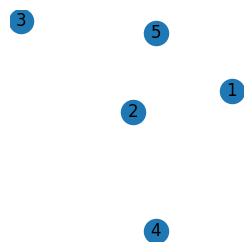

[('1', (1150, 1760)), ('2', (630, 1660)), ('3', (40, 2090)), ('4', (750, 1100)), ('5', (750, 2030))]


In [10]:
cities = [(i,(0,0)) for i in range(5)]
n_mat = nodes_matrix.copy()
for i in range(5):
    cities[i] = (str(n_mat[i][0]), (n_mat[i][1], n_mat[i][2]))
plot_city(cities)
print(cities)

#### But the instance below works

In [ ]:
# City names and coordinates list[("name", (x, y))]
cities = [
    ("a", (0, 0)),
    ("b", (1, 3)),
    ("c", (3, 2)),
    ("d", (2, 1)),
    ("e", (0, 1))
]
plot_city(cities)

#### Prepare binary vector with bit (𝑖,𝑗) representing to visit 𝑗 city at time 𝑖

In [ ]:
n_city = len(cities)
x = Array.create('c', (n_city, n_city), 'BINARY')

In [ ]:
# Constraint not to visit more than two cities at the same time.
time_const = 0.0
for i in range(n_city):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

# Constraint not to visit the same city more than twice.
city_const = 0.0
for j in range(n_city):
    city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

In [ ]:
# distance of route
distance = 0.0
for i in range(n_city):
    for j in range(n_city):
        for k in range(n_city):
            d_ij = dist(i, j, cities)
            distance += d_ij * x[k, i] * x[(k+1)%n_city, j]

In [ ]:
# Construct hamiltonian
A = Placeholder("A")
H = distance + A * (time_const + city_const)

In [ ]:
# Compile model
model = H.compile()

In [ ]:
# Generate QUBO
feed_dict = {'A': 4.0}
bqm = model.to_bqm(feed_dict=feed_dict)

In [ ]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constraint = {}".format(num_broken))

In [ ]:
if num_broken == 0:
    plot_city(cities, best_sample)

## Solve TSP instance with SA (without QUBO formulation)